# Eval WEAC

Initialize models, run over a resolution of 5cm with a standardized weak layer

In [1]:
# Auto reload modules
%load_ext autoreload
%autoreload all

In [2]:
import os

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from weac.analysis.criteria_evaluator import CriteriaEvaluator
from weac.components import Segment, ScenarioConfig, WeakLayer, CriteriaConfig
from weac.utils.snowpilot_parser import convert_to_mm, convert_to_deg


from layerwise.analysis.profile_utils import load_snowpilot_parsers, eval_weac_over_layers

In [23]:
# Settings
run_weac = True

# Standard values
number_of_files = 1
raw_data_dir = "../data/raw/snowpilot"
criteria_data_path = "../data/criteria_data"
csv_file = "../data/weac_over_layers.csv"
plot_dir = "../data/plots"
os.makedirs(criteria_data_path, exist_ok=True)


In [24]:
# Setup Sim values
wl_spacing = 200 # mm
phi = 0.0
scenario_config = ScenarioConfig(system_type="skier", phi=phi)
weak_layer = WeakLayer(rho=125, h=20, E=1.0, sigma_c=6.16, tau_c=5.09)
segments = [
    Segment(length=10000, has_foundation=True, m=0.0),
    Segment(
        length=10000,
        has_foundation=True,
        m=0.0,
    ),
]
criteria_config = CriteriaConfig()
criteria_evaluator = CriteriaEvaluator(criteria_config)

In [25]:
## Parse all snowpilot files

paths, parsers = load_snowpilot_parsers(raw_data_dir, number_of_files)

paths_and_parsers = [
    (path, parser)
    for path, parser in zip(paths, parsers) if bool(parser.snowpit.core_info.location.slope_angle)
]

print(f"\nExtracted {len(paths_and_parsers)} files")


Extracted 1 files


In [26]:
# Extract additional pit information

pit_info_list = []
for _, pit in paths_and_parsers:
    slope_angle = pit.snowpit.core_info.location.slope_angle
    if slope_angle:
        slope_angle_deg = slope_angle[0] * convert_to_deg[slope_angle[1]]
    else:
        slope_angle_deg = 0.0
    hs = pit.snowpit.snow_profile.hs
    if hs:
        hs_mm = hs[0] * convert_to_mm[hs[1]]
    else:
        hs_mm = None
    profile_depth = pit.snowpit.snow_profile.profile_depth
    if profile_depth:
        profile_depth_mm = profile_depth[0] * convert_to_mm[profile_depth[1]]
    else:
        profile_depth_mm = None
    pit_near_avalanche_location = pit.snowpit.core_info.location.pit_near_avalanche_location
    pit_info_dict = {
        "Slope Angle": slope_angle_deg,
        "HS": hs_mm,
        "Profile Depth": profile_depth_mm,
        "Pit Near Avalanche Location": pit_near_avalanche_location,
    }
    pit_info_list.append(pit_info_dict)

print(pit_info_list)

[{'Slope Angle': '29', 'HS': 3000.0, 'Profile Depth': 3000.0, 'Pit Near Avalanche Location': None}]


In [27]:
## Evaluate WEAC over layers
from layerwise.plotting.plotly_snow_profile import snow_profile, criticality_plots, criticality_heatmap, combine_plots

if run_weac:
    
    data_rows = []
    error_pits = []
    
    for (fp, pit), pit_info_dict in tqdm(zip(paths_and_parsers, pit_info_list), total=len(paths_and_parsers), desc="Processing pits"):
        scenario_config = ScenarioConfig(
            phi=pit_info_dict["Slope Angle"],
            system_type="skier",
        )
        try:
            layers, _ = pit.extract_layers()
            print("layers: ", layers)
            pit_analysis_result, layers, weak_layer = eval_weac_over_layers(layers, scenario_config, segments, weak_layer, criteria_evaluator, spacing=wl_spacing)
            # add pit info dict to data row
            data_rows.append(pit_analysis_result)
            
            # Visual Analysis
            dataframe = pd.DataFrame(pit_analysis_result)
            snow_profile_fig = snow_profile(weaklayer=weak_layer, layers=layers)
            crit_plots_fig = criticality_plots(weak_layer, layers, dataframe)
            crit_hm_fig = criticality_heatmap(weak_layer, layers, dataframe)
            combine_plots(plot_dir, os.path.basename(fp), [crit_plots_fig, snow_profile_fig, crit_hm_fig])
            print("Written to: ", os.path.basename(fp))
        except Exception as e:
            error_pits.append(pit)
            print(f"Error processing pit {pit.snowpit.core_info.pit_id}: {e}")
            continue
    
    print(f"Number of pits with errors: {len(error_pits)}")
    print(f"Number of pits processed: {len(data_rows)}")
    print(f"Number of pits total: {len(paths_and_parsers)}")
    
    dataframe = pd.DataFrame(data_rows[0])
    dataframe.to_csv(csv_file, index=False)

Processing pits:   0%|          | 0/1 [00:00<?, ?it/s]

layers:  [Layer(rho=101.0, h=100.0, nu=0.25, E=0.3963944665536936, G=0.15855778662147743, tensile_strength=1.103877672602255, tensile_strength_method='sigrist', E_method='bergfeld', grain_type=<GrainType.DF: 'DF'>, grain_size=None, hand_hardness=<HandHardness.F: 'F'>), Layer(rho=173.0, h=170.0, nu=0.25, E=4.231714820461142, G=1.6926859281844568, tensile_strength=4.1040183019389715, tensile_strength_method='sigrist', E_method='bergfeld', grain_type=<GrainType.DF: 'DF'>, grain_size=None, hand_hardness=<HandHardness._1F: '1F'>), Layer(rho=137.0, h=30.0, nu=0.25, E=1.515947056821604, G=0.6063788227286416, tensile_strength=2.3226029915382136, tensile_strength_method='sigrist', E_method='bergfeld', grain_type=<GrainType.DF: 'DF'>, grain_size=None, hand_hardness=<HandHardness._4F: '4F'>), Layer(rho=209.0, h=300.0, nu=0.25, E=9.722035388607377, G=3.888814155442951, tensile_strength=6.509291720550219, tensile_strength_method='sigrist', E_method='bergfeld', grain_type=<GrainType.DF: 'DF'>, grain


Processing weak layers:   0%|          | 0/15 [00:00<?, ?it/s]

wl_depth:  200.0


wl_depth:  400.0


wl_depth:  600.0


wl_depth:  800.0


wl_depth:  1000.0


wl_depth:  1200.0


wl_depth:  1400.0


wl_depth:  1600.0


wl_depth:  1800.0


wl_depth:  2000.0


wl_depth:  2200.0


wl_depth:  2400.0


wl_depth:  2600.0


wl_depth:  2800.0


wl_depth:  3000.0


Written to:  snowpits-24461-caaml.xml
Number of pits with errors: 0
Number of pits processed: 1
Number of pits total: 1


### Plot first SnowPit

In [28]:
path, parser = paths_and_parsers[0]

dataframe = pd.read_csv(csv_file)
print(dataframe)

# Extract layers
layers, density_method = parser.extract_layers()
print("layers: ", layers)
heights = np.cumsum([layer.h for layer in layers])

# Extract layers for plotting
plot_layers = layers
plot_weaklayer = weak_layer



    wl_depth  impact_criterion  coupled_criterion  sserr_result  \
0      200.0         66.929214          82.698398      1.231344   
1      400.0        128.559627         158.358121      2.838441   
2      600.0        174.765153         216.392055      4.664180   
3      800.0        264.547232         319.181416      6.959860   
4     1000.0        304.941626         365.868702      9.447766   
5     1200.0        317.049473         387.266879     11.936033   
6     1400.0        305.588054         384.610453     14.421611   
7     1600.0        272.237524         356.620009     16.898915   
8     1800.0        217.848467         300.649594     19.381786   
9     2000.0        142.851771         211.276809     21.888306   
10    2200.0         47.184502          76.863998     24.449270   
11    2400.0          0.000000           0.000000     27.112082   
12    2600.0          0.000000           0.000000     29.944770   
13    2800.0          0.000000           0.000000     33.03859

In [29]:
snow_profile_fig = snow_profile(weaklayer=plot_weaklayer, layers=plot_layers)
snow_profile_fig.show()

In [30]:
crit_plots_fig = criticality_plots(plot_weaklayer, plot_layers, dataframe)
# crit_plots_fig.show()

In [31]:
crit_hm_fig = criticality_heatmap(plot_weaklayer, plot_layers, dataframe)
crit_hm_fig.show()

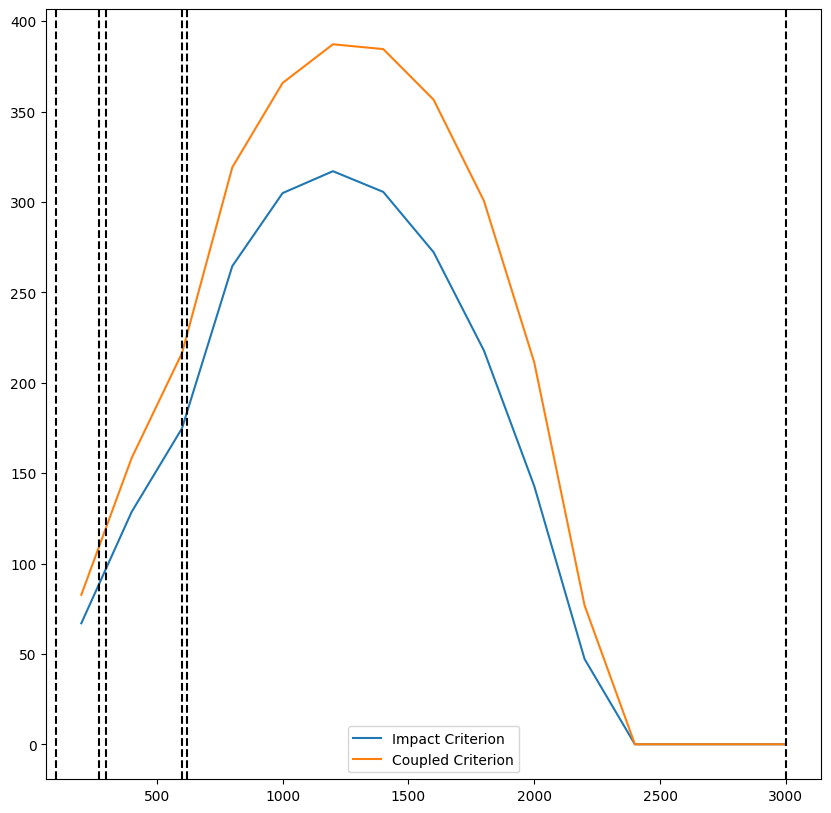

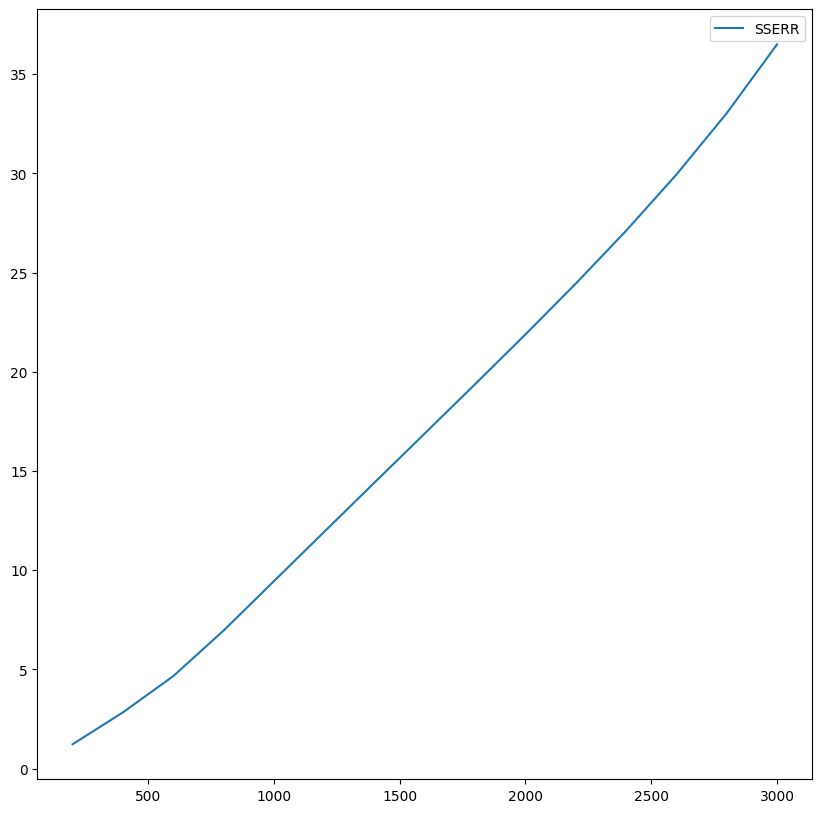

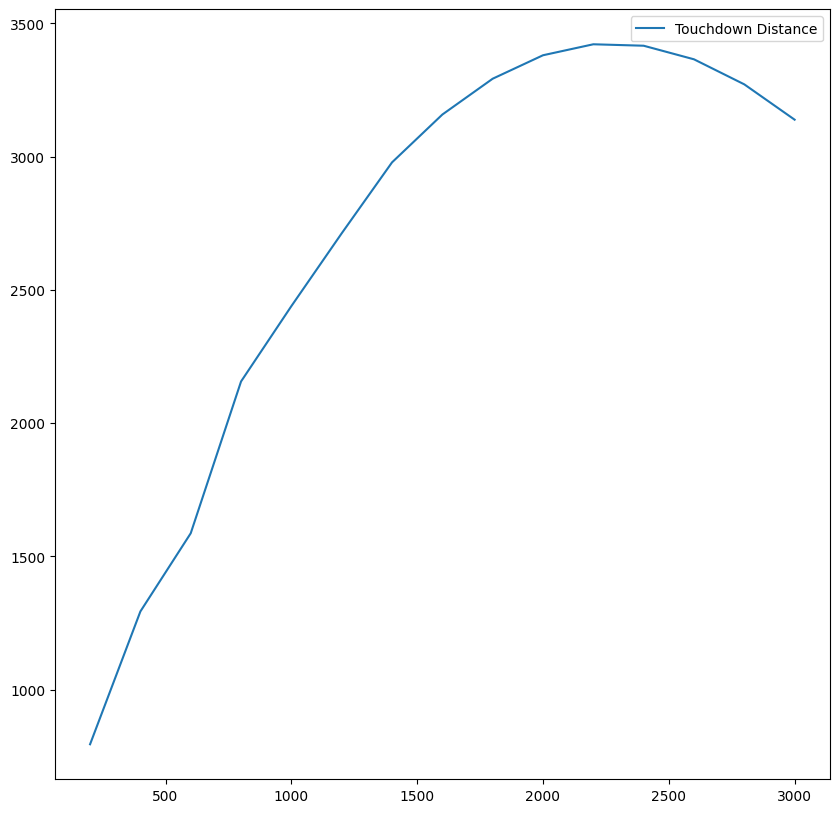

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.plot(dataframe["wl_depth"], dataframe["impact_criterion"], label="Impact Criterion")
plt.plot(dataframe["wl_depth"], dataframe["coupled_criterion"], label="Coupled Criterion")
# plot vertical lines at the end of each layer
for i, height in enumerate(heights):
    plt.axvline(x=height, color="black", linestyle="--")
plt.legend()
# plt.show()

plt.figure(figsize=(10, 10))
plt.plot(dataframe["wl_depth"], dataframe["sserr_result"], label="SSERR")
# plt.ylim(0, 4000)
plt.legend()
# plt.show()

plt.figure(figsize=(10, 10))
plt.plot(dataframe["wl_depth"], dataframe["touchdown_distance"], label="Touchdown Distance")
plt.legend()
# plt.show()

In [33]:
figures = [crit_plots_fig, snow_profile_fig, crit_hm_fig]
combine_plots(plot_dir, "combined", figures)